# Data Exploration

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn import datasets, metrics, svm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [ ]:
X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
y.head()

,class
0,5
1,0
2,4
3,1
4,9


I am going to normalise the feature (training data) values and ensure the labels (targets) are integers.

In [ ]:
X = X / 255.0
y = y.astype(int)

Given that X_train_full contains the flattened images and the y_train_full contains the corresponding targets. Here I image show the first 5 digits, along with their corresponding targets. The key think here is that I reshape the 1x728 data to a 28x28 data so it can be displayed with matplotlib's imshow funcs for 2D images.

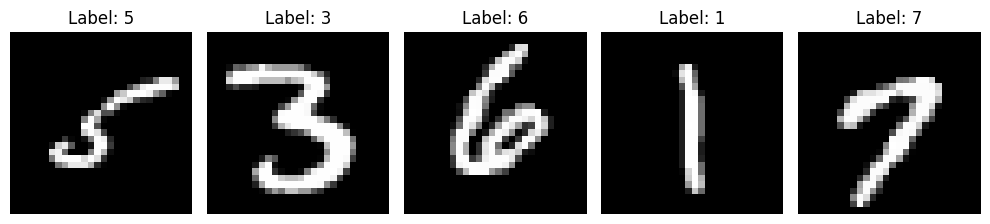

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(10, 5))
for i, ax in enumerate(axes):
  j = i + 11
  digit_image = X.iloc[j].to_numpy().reshape(28,28)
  ax.imshow(digit_image, cmap='gray')
  ax.axis('off')
  ax.set_title(f'Label: {y[j]}')

plt.tight_layout()
# plt.savefig('X.png',dpi=300,bbox_inches='tight')
plt.show()

# Logistic Regression

Split the dataset in train and test data

In [ ]:
X_train, y_train = X[:60000], y[:60000]
X_test, y_test = X[60000:], y[60000:]

print(f'Training data: {X_train.shape}, {y_train.shape}')
print(f'Testing data: {X_test.shape}, {y_test.shape}')

Training data: (60000, 784), (60000,)
Testing data: (10000, 784), (10000,)


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from sklearn.linear_model import LogisticRegression
import joblib

logistic_reg = LogisticRegression(
    max_iter=10000,
    random_state=42
)

logistic_reg.fit(X_train, y_train)
joblib.dump(logistic_reg, 'logistic_reg.joblib')
y_pred = logistic_reg.predict(X_test)

logistic_reg_classf_report = classification_report(y_test, y_pred, output_dict=True)

KeyboardInterrupt: 

# Support Vector Machine

SVMs take really long to train, so instead of training it on 60,000 instance, I will train it on 1,000 instances.
I have found that Randomized search finds, better optimization parameters for MNIST that GridSearch.

In [ ]:
X_train_svm, X_test_svm = X[:1000], X[-1000:]
y_train_svm, y_test_svm = y[:1000], y[-1000:]

print(f'Training sets for SVM: {X_train_svm.shape}, {y_train_svm.shape}')
print(f'Testing sets for SVM: {X_test_svm.shape}, {y_test_svm.shape}')

Training sets for SVM: (1000, 784), (1000,)
Testing sets for SVM: (1000, 784), (1000,)


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_dist = {
  'C': uniform(0, 10),
  'gamma': uniform(0.001, 0.1),
  'kernel': ['linear', 'rbf'],
}

smv_model = SVC()
randomized_search = RandomizedSearchCV(smv_model, param_dist, cv=5, scoring='accuracy')
randomized_search.fit(X_train_svm, y_train_svm)

print(f'Best Params for SVM: {randomized_search.best_params_}')

best_svm_model = randomized_search.best_estimator_
joblib.dump(best_svm_model, 'svm_model.joblib')
y_pred = best_svm_model.predict(X_test_svm)

svm_classf_report = classification_report(y_test_svm, y_pred, output_dict=True)

Best Params for SVM: {'C': 7.3159479695489695, 'gamma': 0.03722009018713446, 'kernel': 'rbf'}


# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

decision_clf = DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=42)

decision_clf.fit(X_train, y_train)
joblib.dump(decision_clf, 'decision_tree.joblib')
y_pred = decision_clf.predict(X_test)

decision_tree_classf_report = classification_report(y_test, y_pred, output_dict=True)

Out of interest, scikit learn can plot the feature importance of the decision tree. In the figure below, it can be vizually seen that the decision tree does indeed correctly think the pixels in the center of the image are the correct pixels to follow.

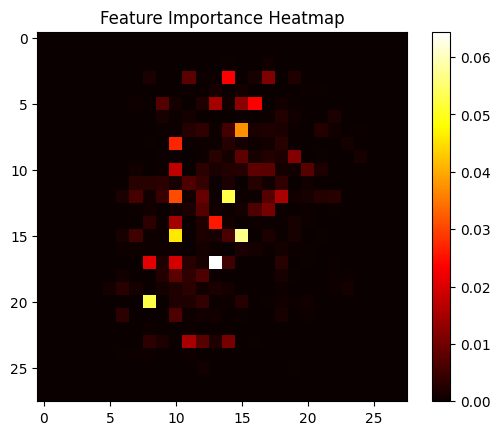

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

feature_importance = decision_clf.feature_importances_
plt.imshow(feature_importance.reshape(28, 28), cmap='hot', interpolation='nearest')
plt.title("Feature Importance Heatmap")
plt.colorbar()
plt.show()


# Neural Net

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

For pytorch neural nets, I will need to create my own Dataset class as torch requires data be structures in its Dataset and Dataloader paradigm before it gets fed into the model.

In [ ]:
class MNISTDataset(Dataset):
  def __init__(self, X, y, x_reshape=None):
    self.X = torch.from_numpy(X.values).type(torch.float32)
    self.y = torch.from_numpy(y.values).type(torch.long)
    self.x_reshape = x_reshape

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    y = self.y[idx]
    x = self.X[idx]
    if self.x_reshape is not None:
      x = x.reshape(self.x_reshape)
    return x, y

print('Testing the torch dataset structure:')
train_dataset = MNISTDataset(X_train, y_train)
print(f'Length of train dataset {train_dataset.__len__()}')
print(f'Shape of instance in dataset {train_dataset.__getitem__(0)[0].shape}')

Testing the torch dataset structure:
Length of train dataset 60000
Shape of instance in dataset torch.Size([784])


In [ ]:
class NeuralNet(nn.Module):
  def __init__(self):
    super(NeuralNet, self).__init__()
    self.fc1 = nn.Linear(28*28, 128)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    return x

In [ ]:
model = NeuralNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataset = MNISTDataset(X_train,y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

for epoch in range(10):
  model.train()
  running_loss = 0.0
  for images, labels in train_loader:
    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

torch.save(model, 'nn_model.pth')

In [ ]:
test_dataset = MNISTDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

all_predictions = []
all_labels = []

model.eval()
with torch.no_grad():
  for images, labels in test_loader:
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    all_predictions.extend(predictions.numpy())
    all_labels.extend(labels.numpy())

nn_classf_report = classification_report(all_labels, all_predictions, output_dict=True)

# CNN

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=3, padding=1),  # 28x28 -> 28x28
        nn.ReLU(),
        nn.MaxPool2d(2)  # 28x28 -> 14x14
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=3, padding=1),  # 14x14 -> 14x14
        nn.ReLU(),
        nn.MaxPool2d(2)  # 14x14 -> 7x7
    )
    self.fc = nn.Linear(32 * 7 * 7, 10)  # 7x7 image, 32 channels -> 10 classes

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = x.view(x.size(0), -1)  # Flatten
    x = self.fc(x)
    return x

In [ ]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataset = MNISTDataset(X_train, y_train, x_reshape=(1, 28, 28))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

for epoch in range(10):
  model.train()
  for images, labels in train_loader:
    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

torch.save(model, 'cnn_model.pth')

In [ ]:
test_dataset = MNISTDataset(X_test, y_test, x_reshape=(1, 28, 28))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

all_predictions = []
all_labels = []

model.eval()
with torch.no_grad():
  for images, labels in test_loader:
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    all_predictions.extend(predictions.numpy())
    all_labels.extend(labels.numpy())

test_dataset = MNISTDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

all_predictions = []
all_labels = []

model.eval()
with torch.no_grad():
  for images, labels in test_loader:
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    all_predictions.extend(predictions.numpy())
    all_labels.extend(labels.numpy())

cnn_classf_report = classification_report(all_labels, all_predictions, output_dict=True)

# Plotting the F1 score as bar charts

In [ ]:
import joblib

logistic_reg = joblib.load('logistic_reg.joblib')
svm_model = joblib.load('svm_model.joblib')
decision_clf = joblib.load('decision_tree.joblib')
logistic_reg_classf_report = classification_report(y_test, logistic_reg.predict(X_test), output_dict=False)
svm_classf_report = classification_report(y_test, svm_model.predict(X_test), output_dict=False)
decision_tree_classf_report = classification_report(y_test, decision_clf.predict(X_test), output_dict=False)

nn_model = torch.load('nn_model.pth')
test_dataset = MNISTDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
all_predictions = []
all_labels = []
nn_model.eval()
with torch.no_grad():
  for images, labels in test_loader:
    outputs = nn_model(images)
    _, predictions = torch.max(outputs, 1)
    all_predictions.extend(predictions.numpy())
    all_labels.extend(labels.numpy())

nn_classf_report = classification_report(all_labels, all_predictions, output_dict=False)

all_predictions.clear()
all_labels.clear()
cnn_model = torch.load('cnn_model.pth')
test_dataset = MNISTDataset(X_test, y_test, x_reshape=(1, 28, 28))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
all_predictions = []
all_labels = []
cnn_model.eval()
with torch.no_grad():
  for images, labels in test_loader:
    outputs = cnn_model(images)
    _, predictions = torch.max(outputs, 1)
    all_predictions.extend(predictions.numpy())
    all_labels.extend(labels.numpy())

cnn_classf_report = classification_report(all_labels, all_predictions, output_dict=False)

# print(logistic_reg_classf_report)
# print(svm_classf_report)
# print(decision_tree_classf_report)
print(nn_classf_report)
print(cnn_classf_report)

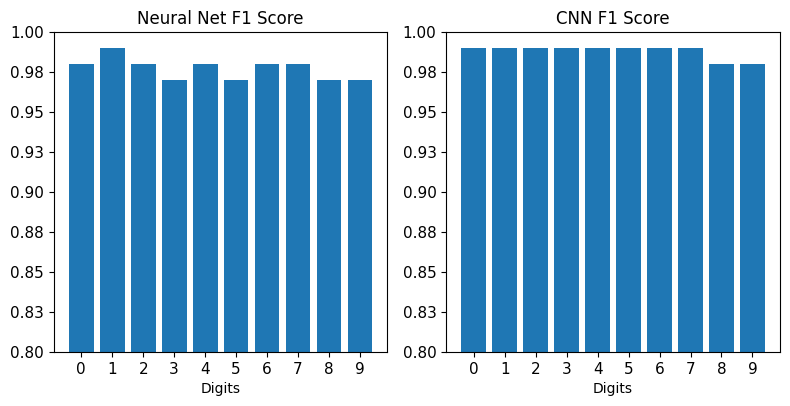

In [ ]:
categories = [0,1,2,3,4,5,6,7,8,9]
logistic_reg_f1_scores = [0.96,0.97,0.91,0.91,0.94,0.88,0.95,0.93,0.88,0.91]
svm_f1_scores = [0.96, 0.98, 0.88, 0.9, 0.9, 0.88, 0.92, 0.92, 0.88, 0.88]
tree_f1_scores = [0.93,0.95,0.85,0.83,0.86,0.81,0.89,0.89,0.8,0.83]
nn_f1_scores = [0.98,0.99,0.98,0.97,0.98,0.97,0.98,0.98,0.97,0.97]
cnn_f1_scores = [0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.98,0.98,]

f1_scores = [
  nn_f1_scores,
  cnn_f1_scores,
  logistic_reg_f1_scores,
  svm_f1_scores,
  tree_f1_scores,
]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

import matplotlib.ticker as ticker
for i in range(0, len(f1_scores) - 3):
  f1_scores[i] = np.array(f1_scores[i])
  axes[i].bar(categories, f1_scores[i])
  axes[i].set_xticks(categories)
  axes[i].tick_params(axis='both', labelsize=11)
  axes[i].set_ylim(0.8, 1)
  axes[i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
  axes[i].set_xlabel('Digits')
plt.tight_layout()

# axes[0].set_title('Logistic Regression F1 Score')
# axes[1].set_title('SVM F1 Score')
# axes[2].set_title('Decision Tree F1 Score')
axes[0].set_title('Neural Net F1 Score')
axes[1].set_title('CNN F1 Score')

# plt.savefig('digit-comparison.png',dpi=300,bbox_inches='tight
plt.savefig('digit-comparison-last-two.png',dpi=300,bbox_inches='tight')
# plt.savefig('digit-comparison-first_three.png',dpi=300,bbox_inches='tight')
plt.show()

# Trying NN and CNN on different sized sets

# Plotting Dataset size vs. Accuracy

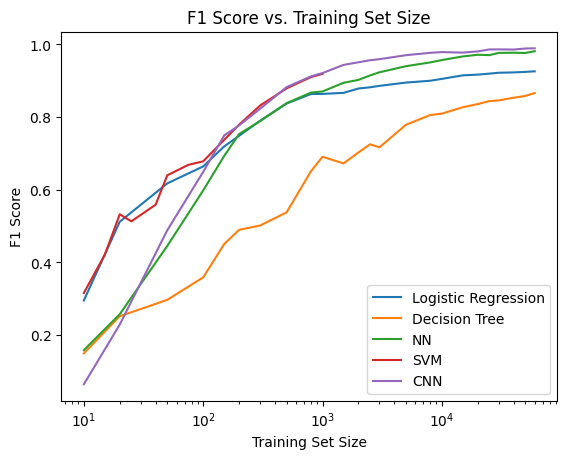

In [ ]:
set_sizes = [
    10, 20, 50, 100, 150, 200, 300, 500, 800, 1000, 1500, 2000, 2500, 3000,
    5000, 8000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 60000
]
set_sizes_svm = [10, 15, 20, 25, 40, 50, 75, 100, 200, 300, 500, 800, 1000]

# Loaded saved from device
logistic_reg_f1_scores = [0.29506779370832337, 0.5118277518842475, 0.6172163609961886, 0.6639426827355271, 0.719038441082119, 0.7482354408319726, 0.7896778648443519, 0.8369158616309678, 0.8631474394081206, 0.863509873029936, 0.8663343645182575, 0.8783185746339257, 0.8816752999207911, 0.8856026622341578, 0.8946549403146701, 0.8997217446932624, 0.9048113634982227, 0.9145675531448358, 0.9165271554180333, 0.9192472412672523, 0.921741954213022, 0.9226133699727825, 0.9240454913411927, 0.9256327606087623]
decision_tree_f1_scores = [0.1495995562811423, 0.2518148969114628, 0.2968235282390297, 0.3585845749500914, 0.45037327645379965, 0.4894939904439051, 0.5013784785016951, 0.5374713201284411, 0.650624233788259, 0.6904970835664519, 0.6723649084636211, 0.7023554550049635, 0.724877514314976, 0.7165067332604758, 0.7784969257235547, 0.8053324302846538, 0.8092310757460104, 0.8267908350136056, 0.8355545830907392, 0.843664186615174, 0.8456077016976413, 0.8530685273219386, 0.8578508934574928, 0.8658499988024845]
svm_f1_scores = [0.315572015732963, 0.42132598425319995, 0.5323225282878793, 0.512851901673701, 0.5587216806593824, 0.6394029452071706, 0.6682005318377037, 0.6779888882090923, 0.7788618307876731, 0.8314600122304832, 0.8787225678783263, 0.9097171322444471, 0.9186585684869729]
nn_f1_scores = [0.15852082110963941, 0.25738183079991095, 0.44507157644146444, 0.5978196799406928, 0.6928319218038527, 0.7529894494446027, 0.7884985315602323, 0.8380040543907404, 0.8670926778587748, 0.870201799831388, 0.8940036108449049, 0.9020595259314778, 0.91419769602995, 0.9229351265497284, 0.9397273420516716, 0.9501663868981017, 0.9566634034261471, 0.9665772047996785, 0.9711892702114832, 0.9701154790896086, 0.9763080865999944, 0.9768100391735545, 0.9761089480597589, 0.980997660924382]
cnn_f1_scores = [0.06446393729218833, 0.2288974642252163, 0.48826090274810074, 0.6488612984971994, 0.7489857882951454, 0.7769040097027733, 0.8226613150355448, 0.8820188789954096, 0.9117112396428778, 0.9208095734489152, 0.9432864424779451, 0.9505109334519822, 0.9561265135509613, 0.9590158844515663, 0.9699788573043883, 0.9765173902192941, 0.9784977496649668, 0.9770848345408125, 0.9803805866862122, 0.9858059966848126, 0.986000235827689, 0.9854910337670133, 0.98839375679534, 0.9888986189659714]

plt.plot(set_sizes, logistic_reg_f1_scores, label='Logistic Regression')
plt.plot(set_sizes, decision_tree_f1_scores, label='Decision Tree')
plt.plot(set_sizes, nn_f1_scores, label='NN')
plt.plot(set_sizes_svm, svm_f1_scores, label='SVM')
plt.plot(set_sizes, cnn_f1_scores, label='CNN')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.legend()
plt.xscale('log')
plt.title('F1 Score vs. Training Set Size')
plt.show()

Set sizes variance on neural nets

In [ ]:
set_sizes = [
    10, 20, 50, 100, 150, 200, 300, 500, 800, 1000, 1500, 2000, 2500, 3000,
    5000, 8000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 60000
]

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

f1_scores = []
for set_size in set_sizes:
  train_dataset = MNISTDataset(X_train[:set_size], y_train[:set_size], x_reshape=(1, 28, 28))
  train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
  test_dataset = MNISTDataset(X_test, y_test, x_reshape=(1, 28, 28))
  test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

  for epoch in range(10):
    model.train()
    for images, labels in train_loader:
      outputs = model(images)
      loss = criterion(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  model.eval()
  with torch.no_grad():
    all_predictions = []
    all_labels = []
    for images, labels in test_loader:
      outputs = model(images)
      _, predictions = torch.max(outputs, 1)
      all_predictions.extend(predictions.numpy())
      all_labels.extend(labels.numpy())

  f1_score = classification_report(all_labels, all_predictions, output_dict=True)['weighted avg']['f1-score']
  f1_scores.append(f1_score)

import json
with open('cnn_f1_scores.json', 'w') as f:
  json.dump(f1_scores, f)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [ ]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

f1_scores = []
for set_size in set_sizes:
  train_dataset = MNISTDataset(X_train[:set_size], y_train[:set_size], x_reshape=(1, 28, 28))
  train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
  test_dataset = MNISTDataset(X_test, y_test, x_reshape=(1, 28, 28))
  test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

  for epoch in range(10):
    model.train()
    for images, labels in train_loader:
      outputs = model(images)
      loss = criterion(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  model.eval()
  with torch.no_grad():
    all_predictions = []
    all_labels = []
    for images, labels in test_loader:
      outputs = model(images)
      _, predictions = torch.max(outputs, 1)
      all_predictions.extend(predictions.numpy())
      all_labels.extend(labels.numpy())

  f1_score = classification_report(all_labels, all_predictions, output_dict=True)['weighted avg']['f1-score']
  f1_scores.append(f1_score)

import json
with open('cnn_f1_scores.json', 'w') as f:
  json.dump(f1_scores, f)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

# Salt and Pepper Noise

In [ ]:
def get_noisy_X(X, noisy_level):
  """ Returns a n x 784 dataframe of noisy images """
  X_noisy = X.values.copy()
  n_cols = X_noisy.shape[1]
  for row in X_noisy:
    random_indices = np.random.choice(n_cols, size=noise_level, replace=False)
    row[random_indices] = 1.0

  return  pd.DataFrame(X_noisy)

In [ ]:
logistic_reg_model = joblib.load('logistic_reg.joblib')
tree_model = joblib.load('decision_tree.joblib')
svm_model = joblib.load('svm_model.joblib')
nn_model = torch.load('nn_model.pth')
cnn_model = torch.load('cnn_model.pth')

noise_levels = list(range(0, 250, 10))
logistic_reg_f1_scores = []
tree_f1_scores = []
svm_f1_scores = []
nn_f1_scores = []
cnn_f1_scores = []

for noise_level in noise_levels:
  X_test = get_noisy_X(X[60000:], noise_level)
  y_test = y[60000:]

  logistic_reg_predictions = logistic_reg_model.predict(X_test)
  tree_predictions = tree_model.predict(X_test)
  svm_predictions = svm_model.predict(X_test)

  nn_model.eval()
  with torch.no_grad():
    all_predictions = []
    all_labels = []
    for images, labels in test_loader:
      outputs = nn_model(images)
      _, predictions = torch.max(outputs, 1)
      all_predictions.extend(predictions.numpy())
      all_labels.extend(labels.numpy())
    nn_f1_scores.append(classification_report(all_labels, all_predictions, output_dict=True)['weighted avg']['f1-score'])

  cnn_model.eval()
  all_predictions.clear()
  all_labels.clear()
  with torch.no_grad():
    for images, labels in test_loader:
      outputs = cnn_model(images)
      _, predictions = torch.max(outputs, 1)
      all_predictions.extend(predictions.numpy())
      all_labels.extend(labels.numpy())
    cnn_f1_scores.append(classification_report(all_labels, all_predictions, output_dict=True)['weighted avg']['f1-score'])

with open('logistic_reg_f1_noisy_scores.json', 'w') as f:
  json.dump(logistic_reg_f1_scores, f)

with open('tree_f1_noisy_scores.json', 'w') as f:
  json.dump(tree_f1_scores, f)

with open('svm_f1_noisy_scores.json', 'w') as f:
  json.dump(svm_f1_scores, f)

with open('nn_noisy_scores.json', 'w') as f:
  json.dump(nn_f1_scores, f)

with open('cnn_f1_noisy_scores.json', 'w') as f:
  json.dump(cnn_f1_scores, f)

FileNotFoundError: [Errno 2] No such file or directory: 'svm_model.joblib'